<a href="https://colab.research.google.com/github/karencfisher/android-classifier/blob/main/notebook/oxford_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tqdm import tqdm

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('OxfordIIITPet',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCIAS7T/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCIAS7T/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
raw_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
module_selection = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

In [6]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [38]:
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

optimize = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimize, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 37)                47397     
                                                                 
Total params: 2,305,381
Trainable params: 47,397
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
hist = model.fit(train_batches,
                 epochs=10,
                 validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 12s 89ms/step - loss: 1.9014 - accuracy: 0.5690 - val_loss: 0.8039 - val_accuracy: 0.8505
Epoch 2/10
92/92 [==============================] - 10s 87ms/step - loss: 0.5649 - accuracy: 0.8933 - val_loss: 0.4735 - val_accuracy: 0.8967
Epoch 3/10
92/92 [==============================] - 14s 131ms/step - loss: 0.3517 - accuracy: 0.9321 - val_loss: 0.3655 - val_accuracy: 0.9049
Epoch 4/10
92/92 [==============================] - 10s 85ms/step - loss: 0.2578 - accuracy: 0.9552 - val_loss: 0.3226 - val_accuracy: 0.9130
Epoch 5/10
92/92 [==============================] - 9s 84ms/step - loss: 0.2020 - accuracy: 0.9674 - val_loss: 0.2949 - val_accuracy: 0.9130
Epoch 6/10
92/92 [==============================] - 10s 85ms/step - loss: 0.1645 - accuracy: 0.9732 - val_loss: 0.2783 - val_accuracy: 0.9103
Epoch 7/10
92/92 [==============================] - 10s 84ms/step - loss: 0.1353 - accuracy: 0.9827 - val_loss: 0.2703 - val_accuracy: 0.9158
Epoch 

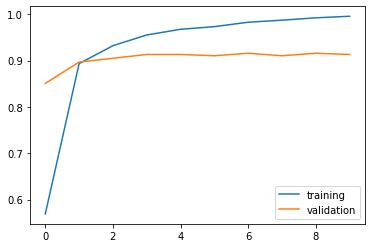

In [40]:
plt.plot(hist.history['accuracy'], label='training')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [41]:
tf.saved_model.save(model, 'OxfordPets')

### Covert the model and save it out

In [42]:
export_file = 'OxfordPets'
convertor = tf.lite.TFLiteConverter.from_saved_model(export_file)
convertor.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = convertor.convert()
tflite_model_file = 'OxfordPets.tflite'

with open(tflite_model_file, 'wb') as FP:
  FP.write(tflite_model)

### Setup interpreter

In [43]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

predictions = []

### Make some predictions

In [44]:
class_names = metadata.features['label'].names
test_batches = raw_test.map(format_image).batch(1)

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


## Show random sample of predictions

In [45]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

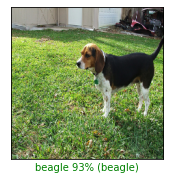

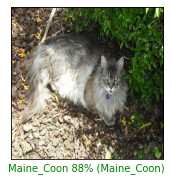

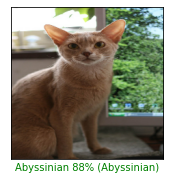

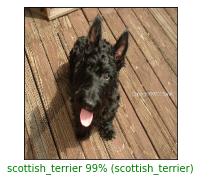

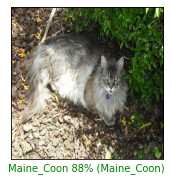

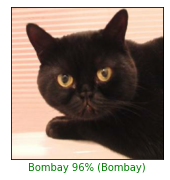

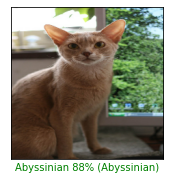

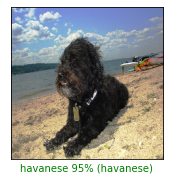

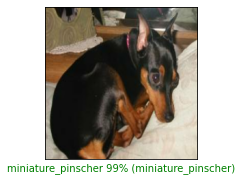

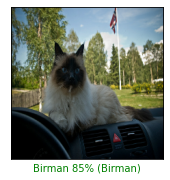

In [48]:
sample = np.random.choice(range(0, 99), size=10)
for index in sample:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

### Try a new uploaded image

In [52]:
import cv2

img = cv2.imread('nyima.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, _ = format_image(img, '')

In [53]:
interpreter.set_tensor(input_index, [img])
interpreter.invoke()
pred = interpreter.get_tensor(output_index)[0]
print(pred)



[3.75716435e-03 1.21536605e-05 2.82967108e-06 7.43493729e-05
 5.82071407e-05 1.13015354e-01 3.42781655e-04 7.24131678e-05
 1.95705379e-05 1.56957103e-04 9.54741267e-07 2.84900912e-03
 1.76632879e-04 1.22799145e-04 1.51869344e-05 6.46432454e-05
 4.03199920e-05 2.67630694e-05 2.68536110e-06 7.23921112e-05
 8.68262231e-01 3.19548462e-06 1.08651970e-04 2.95554590e-03
 5.74114438e-07 1.95226539e-06 7.41391955e-03 1.10802124e-04
 1.30709732e-05 1.59133724e-05 1.29744985e-05 3.90073874e-05
 3.31458905e-05 5.11149301e-05 7.36307641e-07 8.64888571e-05
 7.49971650e-06]


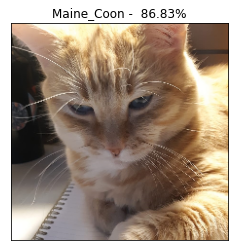

In [54]:
label = np.argmax(pred)

plt.imshow(img, cmap=plt.cm.binary)
plt.title(f'{class_names[label]} - {pred[label] * 100: .2f}%')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

Download the class names

In [51]:
with open('oxford_labels.txt', 'w') as FP:
  FP.writelines('\n'.join(class_names))
